In [78]:
import pandas as pd
import numpy as np
from string import ascii_lowercase
import itertools
import string
from collections import defaultdict
import random
import matplotlib.pyplot as plt
from sklearn import linear_model, ensemble

pd.set_option('display.max_columns', 50)

%matplotlib inline

### Board

In [9]:
def new_game(X_cols):
    return pd.Series(0, X_cols)

def empty_positions(rows, columns):
    return {col:[row for row in rows] for col in columns}

### Winning positions

In [10]:
def rows_and_columns_checked(all_rows, all_columns):
    win_type_positions = {}
    limit_top_rows = all_rows[:-connect_n + 1]
    limit_bottom_rows = all_rows[connect_n - 1:]
    limit_right_columns =  all_columns[:-connect_n + 1]
    
    # create dictionary of win types and a tuple of the rows and columns checked for each win type
    for win_type in win_types:
        if win_type == 'up':
            rows_checked, columns_checked = limit_top_rows, all_columns
        elif win_type == 'across':
            rows_checked, columns_checked = all_rows, limit_right_columns
        elif win_type == 'diag /':
            rows_checked, columns_checked = limit_top_rows, limit_right_columns
        elif win_type == 'diag \\':
            rows_checked, columns_checked = limit_bottom_rows, limit_right_columns
        else:
            raise ValueError('not a valid win type')
        win_type_positions[win_type] = rows_checked, columns_checked

    # create dictionary of individual row/column positions and a list of their possible win types 
    positions_win_types_to_check = defaultdict(list)
    for win_type, rows_and_columns_to_check in win_type_positions.iteritems():
        for positions in itertools.product(rows_and_columns_to_check[0],rows_and_columns_to_check[1]):
            row = positions[0]
            column = positions[1]
            position = column + str(row)
            positions_win_types_to_check[position, (row, column)].append(win_type)
    return positions_win_types_to_check


def win_type_angle(win_type, row_checked, column_checked):

    # list row and column positions
    if win_type == 'up':
        angle_column_positions = list(column_checked) * connect_n
        angle_row_positions = list(map(str, range(row_checked, row_checked + connect_n)))
    elif win_type == 'across':
        angle_column_positions = list(map(chr, range(ord(column_checked), ord(column_checked) + connect_n)))
        angle_row_positions = list(str(row_checked)) * connect_n
    elif win_type == 'diag /':
        angle_column_positions = list(map(chr, range(ord(column_checked), ord(column_checked) + connect_n)))
        angle_row_positions = list(map(str, range(row_checked, row_checked + connect_n)))
    elif win_type == 'diag \\':
        angle_column_positions = list(map(chr, range(ord(column_checked), ord(column_checked) + connect_n)))
        angle_row_positions = list(map(str, range(row_checked, row_checked - connect_n, -1)))
    else:
        raise ValueError('not a valid win type')

    # combine postitions
    return [column + row for column, row in zip(angle_column_positions, angle_row_positions)]


def get_winning_positions(positions_win_types_to_check):
    winning_positions = defaultdict(list)
    for position, position_win_types in positions_win_types_to_check.iteritems():
        row = position[1][0]
        column = position[1][1]
        for win_type in position_win_types:
            additional_positions_to_check = win_type_angle(win_type, row, column)
            winning_positions[position[0]].append((win_type, additional_positions_to_check))
    return winning_positions

### Check for win

In [79]:
def determine_player(game_move_count):
    player_choice = (game_move_count + 1) % 2
    player_choice *= 2
    player_choice -= 1
    return player_choice


def available_moves(player, remaining_empty_positions):
    return [col + str(rows[0]) for col, rows in remaining_empty_positions.iteritems() if rows != list()]


def remove_empty_position(choosen_move, remaining_empty_positions):
    remaining_empty_positions[choosen_move[0]].pop(0)
    return remaining_empty_positions


def check_positions(game):
    return game[game != 0].index


def obvious_win(game, remaining_empty_positions, winning_positions, player):
    # has_best_move  BOOLEAN
    # move_to_make   STRING board_position OR NULL
    for board_position in check_positions(game):
        for win_type_angle in winning_positions[board_position]:
            game_positions_of_win_type_angle = game[win_type_angle[1]]
            win_type_angle_status = game[win_type_angle[1]].value_counts()
            if len(win_type_angle_status) == 2 and 0 in win_type_angle_status.index and player in win_type_angle_status.index:
                if win_type_angle_status.loc[0] == 1 and win_type_angle_status.loc[player] == 3:
                    winning_move = game_positions_of_win_type_angle[game_positions_of_win_type_angle == 0].index[0]
                    if winning_move in available_moves(player, remaining_empty_positions):
                        return True, winning_move
    return False, None



def predict_best_move(game, remaining_empty_positions, winning_positions, player, player_1_algo, player_2_algo):
    if player == 1:
        if player_1_algo == 'random_algo':
            return random.choice(available_moves(player, remaining_empty_positions))
        if player_2_algo == 'linear':
            win_probabilities = {}
            for possible_move in available_moves(player, remaining_empty_positions):
                possible_game = determine_new_board_positions(game, possible_move, player)
                player_prob_position = [np.argmax(lr.classes_ == player)][0] 
                win_probability = lr.predict_proba(possible_game)[0][player_prob_position]
                win_probabilities[possible_move] = win_probability
            return max(win_probabilities, key=win_probabilities.get)
        if player_2_algo == 'rf':
            win_probabilities = {}
            for possible_move in available_moves(player, remaining_empty_positions):
                possible_game = determine_new_board_positions(game, possible_move, player)
                player_prob_position = [np.argmax(lr.classes_ == player)][0] 
                win_probability = rf.predict_proba(possible_game)[0][player_prob_position]
                win_probabilities[possible_move] = win_probability
            return max(win_probabilities, key=win_probabilities.get)
        
    else:
        if player_2_algo == 'random_algo':
            return random.choice(available_moves(player, remaining_empty_positions))
        if player_2_algo == 'linear':
            win_probabilities = {}
            for possible_move in available_moves(player, remaining_empty_positions):
                possible_game = determine_new_board_positions(game, possible_move, player)
                player_prob_position = [np.argmax(lr.classes_ == player)][0] 
                win_probability = lr.predict_proba(possible_game)[0][player_prob_position]
                win_probabilities[possible_move] = win_probability
            return max(win_probabilities, key=win_probabilities.get)
        if player_2_algo == 'rf':
            win_probabilities = {}
            for possible_move in available_moves(player, remaining_empty_positions):
                possible_game = determine_new_board_positions(game, possible_move, player)
                player_prob_position = [np.argmax(lr.classes_ == player)][0] 
                win_probability = rf.predict_proba(possible_game)[0][player_prob_position]
                win_probabilities[possible_move] = win_probability
            return max(win_probabilities, key=win_probabilities.get)

def choose_move(game, remaining_empty_positions, winning_positions, player, player_1_algo, player_2_algo):
    # new_board_positions  DICT all board positions
    has_obvious_win = obvious_win(game, remaining_empty_positions, winning_positions, player) 
    if has_obvious_win[0] == True:
        choosen_move = has_obvious_win[1]
        has_won_game = True
    else:
        choosen_move = predict_best_move(game, remaining_empty_positions, winning_positions, player, player_1_algo, player_2_algo)
        has_won_game = False
    return (choosen_move, has_won_game)


def determine_new_board_positions(game, choosen_move, player):
    possible_game = game.copy(deep = True)
    possible_game[choosen_move] = player
    return possible_game

In [80]:
def play_game(winning_positions, player_1_algo, player_2_algo):
    game = new_game(X_cols)
    remaining_empty_positions = empty_positions(rows, columns)
    game_progress = pd.DataFrame(columns = X_cols)
    for game_move_count in range(len(game)):
        player = determine_player(game_move_count)
        choosen_move, has_won_game = choose_move(game, remaining_empty_positions, winning_positions, player, player_1_algo, player_2_algo)
        game = determine_new_board_positions(game, choosen_move, player)
        game_progress = game_progress.append(game, ignore_index=True)
        remaining_empty_positions = remove_empty_position(choosen_move, remaining_empty_positions)
        if has_won_game == True:
            return (player, game, game_progress)
    return (0, game, game_progress)

In [13]:
connect_n = 4
board_height = 6
board_width = 7 # max 26
columns = [column for column in ascii_lowercase[:board_width]]
rows = [row for row in range(board_height)]
X_cols = []
for column in ascii_lowercase[:board_width]:
    for row in range(board_height):
        X_cols.append(column + str(row))

In [14]:
np.random.seed(seed = 1)
X_rand = pd.DataFrame(np.random.randint(3, size=(1000, len(X_cols)), ), columns=X_cols) - 1
win_types = ['up', 'across', 'diag /', 'diag \\']

In [15]:
positions_win_types_to_check = rows_and_columns_checked(rows, columns)
winning_positions = get_winning_positions(positions_win_types_to_check)

In [16]:
random.seed(0)
# all_cols = X_cols.append("Winner")
df_games = pd.DataFrame(0, index = [0], columns = X_cols + ['Winner'])
df_games_progress =  pd.DataFrame(0, index = [0], columns = X_cols + ['Winner'])

In [81]:
number_of_games = 10

In [18]:
%%time
for game_number in range(100):
    winner, game, game_progress = play_game(winning_positions, 'random_algo', 'random_algo')
    game_info = game.append(pd.Series(winner, index = ['Winner']))
    df_games = df_games.append(game_info, ignore_index = True)
    game_progress['Winner'] = winner
    df_games_progress = df_games_progress.append(game_progress, ignore_index = True)

CPU times: user 25.8 s, sys: 117 ms, total: 25.9 s
Wall time: 25.9 s


In [95]:
%%time
for game_number in range(number_of_games):
    lr = linear_model.LogisticRegression()
    lr.fit(df_games_progress.iloc[:,:len(X_cols)], df_games_progress.Winner)
    rf = ensemble.RandomForestClassifier(n_estimators=25, n_jobs=-1)
    rf.fit(df_games_progress.iloc[:,:len(X_cols)], df_games_progress.Winner)
    winner, game, game_progress = play_game(winning_positions, 'rf', 'rf')
    game_info = game.append(pd.Series(winner, index = ['Winner']))
    df_games = df_games.append(game_info, ignore_index = True)
    game_progress['Winner'] = winner
    df_games_progress = df_games_progress.append(game_progress, ignore_index = True)

CPU times: user 12 s, sys: 4.26 s, total: 16.3 s
Wall time: 2min 16s


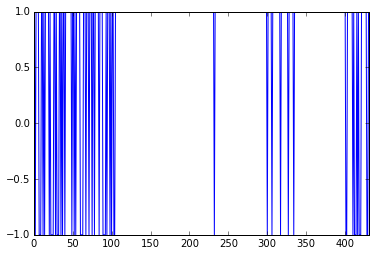

In [96]:
df_games.Winner.plot()

In [89]:
df_games_progress_full = df_games_progress.append(df_games_progress * -1)

In [93]:
df_games.Winner.value_counts()

 1    365
-1     55
 0      1
dtype: int64

In [94]:
df_games_progress


,a0,a1,a2,a3,a4,a5,b0,b1,b2,b3,b4,b5,c0,c1,c2,c3,c4,c5,d0,d1,d2,d3,d4,d5,e0,e1,e2,e3,e4,e5,f0,f1,f2,f3,f4,f5,g0,g1,g2,g3,g4,g5,Winner
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
5,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
6,0,0,0,0,0,0,1,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
7,0,0,0,0,0,0,1,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,1
8,0,0,0,0,0,0,1,-1,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,1
9,0,0,0,0,0,0,1,-1,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,1


In [83]:
df_games.Winner.value_counts()

 1    362
-1     48
 0      1
dtype: int64

In [77]:
df_games.Winner.value_counts()

 1    355
-1     45
 0      1
dtype: int64

In [26]:
df_games_progress

,a0,a1,a2,a3,a4,a5,b0,b1,b2,b3,b4,b5,c0,c1,c2,c3,c4,c5,d0,d1,d2,d3,d4,d5,e0,e1,e2,e3,e4,e5,f0,f1,f2,f3,f4,f5,g0,g1,g2,g3,g4,g5,Winner
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
5,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
6,0,0,0,0,0,0,1,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
7,0,0,0,0,0,0,1,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,1
8,0,0,0,0,0,0,1,-1,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,1
9,0,0,0,0,0,0,1,-1,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,1


In [29]:
df_games_progress.iloc[4880:]

,a0,a1,a2,a3,a4,a5,b0,b1,b2,b3,b4,b5,c0,c1,c2,c3,c4,c5,d0,d1,d2,d3,d4,d5,e0,e1,e2,e3,e4,e5,f0,f1,f2,f3,f4,f5,g0,g1,g2,g3,g4,g5,Winner
4880,-1,1,-1,0,0,0,1,1,-1,0,0,0,-1,1,1,-1,1,0,1,-1,1,-1,0,0,-1,1,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,1
4881,-1,1,-1,0,0,0,1,1,-1,0,0,0,-1,1,1,-1,1,0,1,-1,1,-1,0,0,-1,1,-1,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,1
4882,-1,1,-1,0,0,0,1,1,-1,0,0,0,-1,1,1,-1,1,0,1,-1,1,-1,0,0,-1,1,-1,1,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,1
4883,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4884,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4885,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4886,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4887,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4888,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,1,-1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1
4889,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,1,-1,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,1


In [32]:
old_row = df_games_progress.iloc[4883 , :len(X_cols)]
old_row = old_row * 0
for idx, row in df_games_progress.iloc[4883 :4902 , :len(X_cols)].iterrows():
    print row[old_row != row].to_dict()
    old_row = row

{'d0': 1.0}
{'d1': -1.0}
{'d2': 1.0}
{'d3': -1.0}
{'b0': 1.0}
{'f0': -1.0}
{'f1': 1.0}
{'c0': -1.0}
{'c1': 1.0}
{'a0': -1.0}
{'a1': 1.0}
{'a2': -1.0}
{'b1': 1.0}
{'c2': -1.0}
{'c3': 1.0}
{'c4': -1.0}
{'b2': 1.0}
{'e0': -1.0}
{'d4': 1.0}


In [33]:
old_row = df_games_progress.iloc[4902  , :len(X_cols)]
old_row = old_row * 0
for idx, row in df_games_progress.iloc[4902  :, :len(X_cols)].iterrows():
    print row[old_row != row].to_dict()
    old_row = row

{'d0': 1.0}
{'d1': -1.0}
{'d2': 1.0}
{'d3': -1.0}
{'b0': 1.0}
{'c0': -1.0}
{'c1': 1.0}
{'f0': -1.0}
{'f1': 1.0}
{'b1': -1.0}
{'a0': 1.0}
{'a1': -1.0}
{'a2': 1.0}
{'b2': -1.0}
{'c2': 1.0}
{'c3': -1.0}
{'c4': 1.0}
{'d4': -1.0}


In [34]:
df_games_progress

,a0,a1,a2,a3,a4,a5,b0,b1,b2,b3,b4,b5,c0,c1,c2,c3,c4,c5,d0,d1,d2,d3,d4,d5,e0,e1,e2,e3,e4,e5,f0,f1,f2,f3,f4,f5,g0,g1,g2,g3,g4,g5,Winner
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
5,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
6,0,0,0,0,0,0,1,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,1
7,0,0,0,0,0,0,1,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,1
8,0,0,0,0,0,0,1,-1,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,1
9,0,0,0,0,0,0,1,-1,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,1


In [35]:
df_games

,a0,a1,a2,a3,a4,a5,b0,b1,b2,b3,b4,b5,c0,c1,c2,c3,c4,c5,d0,d1,d2,d3,d4,d5,e0,e1,e2,e3,e4,e5,f0,f1,f2,f3,f4,f5,g0,g1,g2,g3,g4,g5,Winner
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,-1,-1,0,0,0,-1,1,-1,0,0,0,-1,1,0,0,0,0,1,1,-1,0,0,0,1,1,0,0,0,0,1,-1,1,-1,0,0,1
2,-1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,-1,-1,-1,-1,0,0,1,1,1,0,0,0,1,-1,-1,1,1,-1,1,-1,-1,0,0,0,-1
3,1,-1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,0,0,0,1
4,-1,0,0,0,0,0,-1,0,0,0,0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,-1,1,1,0,0,0,-1,0,0,0,0,0,1
5,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,-1,1,1,1,1,0,1,-1,0,0,0,0,-1,0,0,0,0,0,1
6,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,-1,-1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,1,0,0,0,0,0,1,0,0,0,0,0,-1,1,0,0,0,0,-1,1,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,-1
8,0,0,0,0,0,0,-1,1,0,0,0,0,-1,0,0,0,0,0,1,-1,0,0,0,0,1,-1,-1,0,0,0,-1,1,1,-1,1,1,1,-1,1,-1,0,0,-1
9,1,-1,1,-1,0,0,1,0,0,0,0,0,-1,1,-1,0,0,0,1,-1,-1,1,1,0,1,1,-1,0,0,0,-1,1,-1,0,0,0,-1,1,1,-1,-1,0,-1


In [39]:
game_dict = df_games.iloc[300, :-1].to_dict()

In [48]:
game_dict['a0']

1

In [52]:
game_dict

{'a0': 1,
 'a1': -1,
 'a2': 1,
 'a3': 0,
 'a4': 0,
 'a5': 0,
 'b0': 1,
 'b1': -1,
 'b2': -1,
 'b3': 0,
 'b4': 0,
 'b5': 0,
 'c0': -1,
 'c1': 1,
 'c2': 1,
 'c3': -1,
 'c4': 1,
 'c5': 0,
 'd0': 1,
 'd1': -1,
 'd2': 1,
 'd3': -1,
 'd4': -1,
 'd5': 0,
 'e0': 0,
 'e1': 0,
 'e2': 0,
 'e3': 0,
 'e4': 0,
 'e5': 0,
 'f0': -1,
 'f1': 1,
 'f2': 0,
 'f3': 0,
 'f4': 0,
 'f5': 0,
 'g0': 0,
 'g1': 0,
 'g2': 0,
 'g3': 0,
 'g4': 0,
 'g5': 0}

In [72]:
d

{'a': {}, 'b': {}, 'c': {}, 'd': {}, 'e': {}, 'f': {}, 'g': {}}

In [50]:
df_games.Winner[201:].value_counts()

 1    98
-1     2
dtype: int64

In [68]:
df_games_progress.iloc[6480:]

,a0,a1,a2,a3,a4,a5,b0,b1,b2,b3,b4,b5,c0,c1,c2,c3,c4,c5,d0,d1,d2,d3,d4,d5,e0,e1,e2,e3,e4,e5,f0,f1,f2,f3,f4,f5,g0,g1,g2,g3,g4,g5,Winner


In [250]:
# random player -1 wins ~ 40% of games

In [251]:
# if both players use logistic regression player 1 wins 100% of games

In [197]:
df_games

,a0,a1,a2,a3,a4,a5,b0,b1,b2,b3,b4,b5,c0,c1,c2,c3,c4,c5,d0,d1,d2,d3,d4,d5,e0,e1,e2,e3,e4,e5,f0,f1,f2,f3,f4,f5,g0,g1,g2,g3,g4,g5,Winner
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,-1,-1,0,0,0,-1,1,-1,0,0,0,-1,1,0,0,0,0,1,1,-1,0,0,0,1,1,0,0,0,0,1,-1,1,-1,0,0,1
2,-1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,-1,-1,-1,-1,0,0,1,1,1,0,0,0,1,-1,-1,1,1,-1,1,-1,-1,0,0,0,-1
3,1,-1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,0,0,0,1
4,-1,0,0,0,0,0,-1,0,0,0,0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,-1,1,1,0,0,0,-1,0,0,0,0,0,1
5,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,-1,1,1,1,1,0,1,-1,0,0,0,0,-1,0,0,0,0,0,1
6,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,-1,-1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,1,0,0,0,0,0,1,0,0,0,0,0,-1,1,0,0,0,0,-1,1,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,-1
8,0,0,0,0,0,0,-1,1,0,0,0,0,-1,0,0,0,0,0,1,-1,0,0,0,0,1,-1,-1,0,0,0,-1,1,1,-1,1,1,1,-1,1,-1,0,0,-1
9,1,-1,1,-1,0,0,1,0,0,0,0,0,-1,1,-1,0,0,0,1,-1,-1,1,1,0,1,1,-1,0,0,0,-1,1,-1,0,0,0,-1,1,1,-1,-1,0,-1


In [198]:
zip(lr.predict_proba(df_games.iloc[:,:len(X_cols)]), df_games.Winner)

[(array([ 0.38534641,  0.00269793,  0.61195566]), 0),
 (array([ 0.61647948,  0.00142616,  0.38209437]), 1),
 (array([ 0.86288557,  0.00112747,  0.13598697]), -1),
 (array([ 0.1607919 ,  0.00156272,  0.83764538]), 1),
 (array([ 0.08713675,  0.00563046,  0.90723279]), 1),
 (array([ 0.60959673,  0.00378653,  0.38661674]), 1),
 (array([ 0.83780213,  0.00114671,  0.16105116]), 1),
 (array([ 0.29062221,  0.00294296,  0.70643482]), -1),
 (array([ 0.65862428,  0.00330493,  0.33807079]), -1),
 (array([ 0.75677982,  0.00323076,  0.23998942]), -1),
 (array([ 0.16750218,  0.00433847,  0.82815935]), 1),
 (array([ 0.64927756,  0.00407436,  0.34664807]), 1),
 (array([ 0.67356581,  0.00168658,  0.32474761]), -1),
 (array([ 0.08268478,  0.00108813,  0.91622709]), 1),
 (array([ 0.73084488,  0.00276793,  0.26638719]), -1),
 (array([ 0.03020782,  0.00163657,  0.96815561]), 1),
 (array([ 0.19095351,  0.00200494,  0.80704155]), 1),
 (array([ 0.19185946,  0.0018408 ,  0.80629974]), 1),
 (array([ 0.23155164, 

In [115]:
player = -1 

0